In [5]:
import pandas as pd 
import os
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns 

In [17]:
parh_url = os.getcwd()
base_path = Path(parh_url)

In [7]:
# Объединяем все csv файлы в один DataFrame

all_data = []
# Рекурсивный обход папок
for date_dir in base_path.iterdir():
    if date_dir.is_dir():
        date = date_dir.name 
        for user_dir in date_dir.iterdir():
            if user_dir.is_dir():
                user_name = user_dir.name  
                for file_path in user_dir.glob('*.csv'):
                    # Чтение CSV файла
                    df = pd.read_csv(file_path)
                    # Добавление колонок с именем пользователя и датой
                    df['name'] = user_name
                    df['date'] = date
                    all_data.append(df)

# Объединение всех данных в один DataFrame
df = pd.concat(all_data,ignore_index=True)
df = df.drop('Unnamed: 0', axis=1)


In [8]:
df

,product_id,quantity,name,date
0,56,4,Vasiliy_Fedorov,2020-12-06
1,97,3,Vasiliy_Fedorov,2020-12-06
2,79,3,Vasiliy_Fedorov,2020-12-06
3,29,5,Vasiliy_Fedorov,2020-12-06
4,73,5,Alexey_Fedorov,2020-12-08
...,...,...,...,...
156,3,4,Kirill_Fedorov,2020-12-04
157,89,5,Kirill_Fedorov,2020-12-04
158,75,2,Kirill_Fedorov,2020-12-04
159,41,5,Kirill_Fedorov,2020-12-04


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   product_id  161 non-null    int64 
 1   quantity    161 non-null    int64 
 2   name        161 non-null    object
 3   date        161 non-null    object
dtypes: int64(2), object(2)
memory usage: 5.2+ KB


### Пользователи, которые совершили больше всего покупок 

In [10]:
df.groupby('name', as_index = False) \
    .agg({'quantity': 'sum'}) \
    .sort_values('quantity', ascending=False)\
    .rename(columns={'quantity' : 'amount_of_purchases'}) \
    .pipe(lambda x: x[x['amount_of_purchases'] == x['amount_of_purchases'].max()])\
    .reset_index(drop=True)

,name,amount_of_purchases
0,Alexey_Smirnov,52
1,Petr_Smirnov,52


### Топ-10 товаров по числу проданных единиц 

In [11]:
top_10_product = df.groupby('product_id', as_index = False) \
    .agg({'quantity': 'sum'}) \
    .sort_values('quantity', ascending=False) \
    .rename(columns={'quantity': 'number_of_purchases'}) \
    .reset_index(drop=True).head(10)
top_10_product

,product_id,number_of_purchases
0,27,20
1,56,18
2,24,15
3,74,15
4,41,14
5,34,13
6,94,13
7,66,13
8,92,12
9,50,12


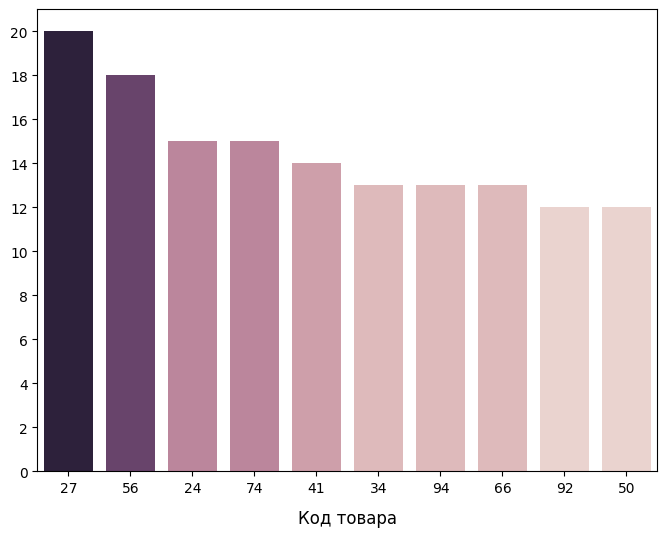

In [12]:
# Визуализация
sorted_top = top_10_product.product_id.to_list()
plt.figure(figsize=(8,6))
sns.color_palette("rocket", as_cmap=True)
sns.barplot(data=top_10_product, x='product_id', y='number_of_purchases',hue = 'number_of_purchases', legend=False, saturation=0.8, order=sorted_top)
plt.yticks(np.arange(0,22,2))
plt.ylabel('')
plt.xlabel('Код товара', labelpad=10, fontsize=12)
plt.show()

### Сколько пользователей приобрели какой-либо товар повторно (более 1 раза)? Повтором будем считать покупку товара с одинаковым product_id, совершенную в разные дни. 

In [13]:
df.groupby(['name', 'product_id'], as_index=False).agg({'quantity':'count'}).query('quantity > 1')


,name,product_id,quantity
30,Alexey_Smirnov,55,2
37,Anton_Ivanov,15,2
92,Petr_Fedorov,94,2


In [14]:
list_name = ['Alexey_Smirnov', 'Anton_Ivanov', 'Petr_Fedorov']
repeat_df = df[df['name'].isin(list_name)]
repeat_df.groupby(['name','product_id'],as_index=False)['date'].nunique()\
    .rename(columns={'date':'purchases'}).query('purchases>1').reset_index(drop=True)

,name,product_id,purchases
0,Anton_Ivanov,15,2
1,Petr_Fedorov,94,2


### Динамика продаж товаров по дням 

In [15]:
date_df = df.groupby('date', as_index=False) \
    .agg({'product_id': 'count'}) \
    .rename(columns={'product_id':'amount'}) \
    .sort_values('date').reset_index(drop=True)
date_df

,date,amount
0,2020-12-03,22
1,2020-12-04,35
2,2020-12-05,23
3,2020-12-06,4
4,2020-12-07,31
5,2020-12-08,23
6,2020-12-09,23


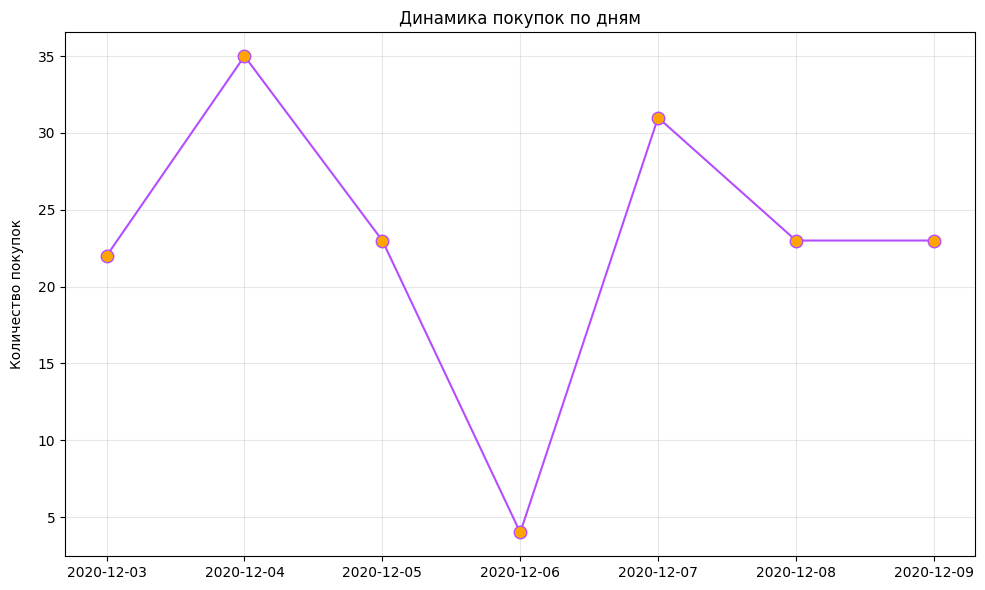

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(date_df.date, date_df.amount,color = (0.71, 0.3, 1.0), marker = 'o',markersize=9,mfc='orange')
plt.ylabel('Количество покупок',labelpad=10)
plt.title('Динамика покупок по дням')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()